In [1]:
import json

In [2]:
SRC_SG_PATH = "../VG-data/scene_graphs.json"

In [3]:
sg_data = json.load(open(SRC_SG_PATH, 'r'))
print(len(sg_data)) # num-images

108077


In [9]:
sg_image = sg_data[0]
sg_image.keys()

dict_keys(['relationships', 'image_id', 'objects'])

In [23]:
img_id = sg_image['image_id']
img_id

1

In [12]:
sg_img_objs = sg_image['objects']
len(sg_img_objs)

40

In [13]:
sg_img_rels = sg_image['relationships']
len(sg_img_rels)

41

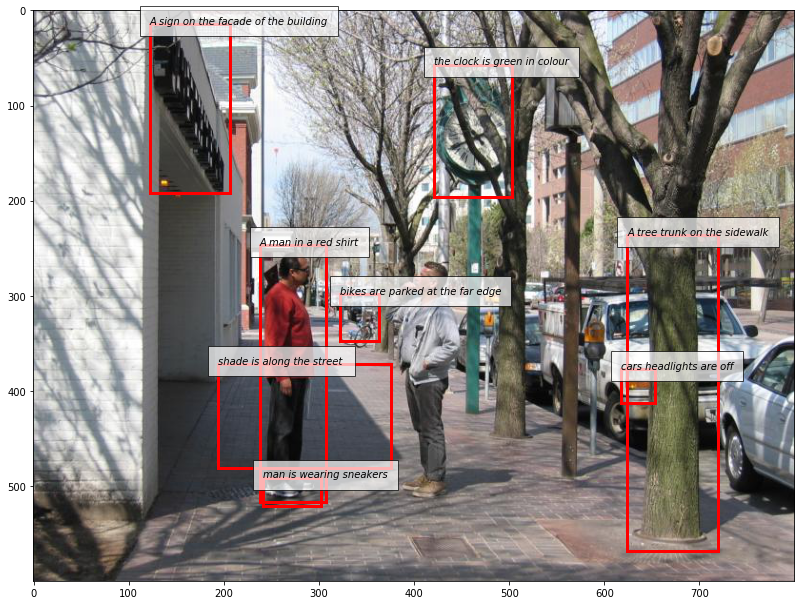

In [25]:
from visual_genome import api as vg
import matplotlib.pyplot as plt
import requests
from matplotlib.patches import Rectangle
from PIL import Image as PIL_Image
from io import BytesIO

image1 = vg.get_image_data(id=img_id)
regions1 = vg.get_region_descriptions_of_image(id=img_id)

fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
def visualize_regions(image, regions):
    response = requests.get(image.url)
    img = PIL_Image.open(BytesIO(response.content))
    plt.imshow(img)
    ax = plt.gca()
    for region in regions:
        ax.add_patch(Rectangle((region.x, region.y),
                               region.width,
                               region.height,
                               fill=False,
                               edgecolor='red',
                               linewidth=3))
        ax.text(region.x, region.y, region.phrase, style='italic', bbox={'facecolor':'white', 'alpha':0.7, 'pad':10})
    fig = plt.gcf()
    plt.tick_params(labelbottom='off', labelleft='off')
    plt.show()
    
visualize_regions(image1, regions1[:8])

# objects

In [14]:
sg_img_obj1 = sg_img_objs[0]
sg_img_obj1
# name, object_id, [x, y, h, w], ['green', 'tall']

{'synsets': ['clock.n.01'],
 'h': 339,
 'object_id': 1058498,
 'names': ['clock'],
 'w': 79,
 'attributes': ['green', 'tall'],
 'y': 91,
 'x': 421}

# Relationships

In [26]:
sg_img_rels1 = sg_img_rels[0]
sg_img_rels1
# ['predicate', 'sub_id', 'obj_id']

{'synsets': ['along.r.01'],
 'predicate': 'ON',
 'relationship_id': 15927,
 'object_id': 5046,
 'subject_id': 5045}

# Generation SG

In [83]:
import networkx as nx

# G = nx.Graph()
G = nx.DiGraph() # directed graph

for sg_img_obj in sg_img_objs: # name, object_id, [x, y, h, w], ['green', 'tall']
    img_bbox = [sg_img_obj['x'], sg_img_obj['y'], sg_img_obj['w'], sg_img_obj['h']]
    G.add_node(sg_img_obj['object_id'], name=sg_img_obj['names'], bbox=img_bbox, attr=sg_img_obj.get('attributes'))

for sg_img_rel in sg_img_rels:
    G.add_edge(sg_img_rel['subject_id'], sg_img_rel['object_id'], predicate=sg_img_rel['predicate'], rel_id=sg_img_rel['relationship_id'])
    
    

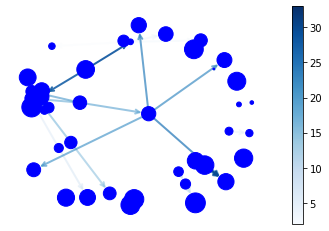

In [40]:
import matplotlib as mpl

pos = nx.layout.spring_layout(G)

node_sizes = [3 + 10 * i for i in range(len(G))]
M = G.number_of_edges()
edge_colors = range(2, M + 2)
edge_alphas = [(5 + i) / (M + 4) for i in range(M)]

nodes = nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color="blue")
edges = nx.draw_networkx_edges(
    G,
    pos,
    node_size=node_sizes,
    arrowstyle="->",
    arrowsize=10,
    edge_color=edge_colors,
    edge_cmap=plt.cm.Blues,
    width=2,
)
# set alpha value for each edge
for i in range(M):
    edges[i].set_alpha(edge_alphas[i])

pc = mpl.collections.PatchCollection(edges, cmap=plt.cm.Blues)
pc.set_array(edge_colors)
plt.colorbar(pc)

ax = plt.gca()
ax.set_axis_off()
plt.show()

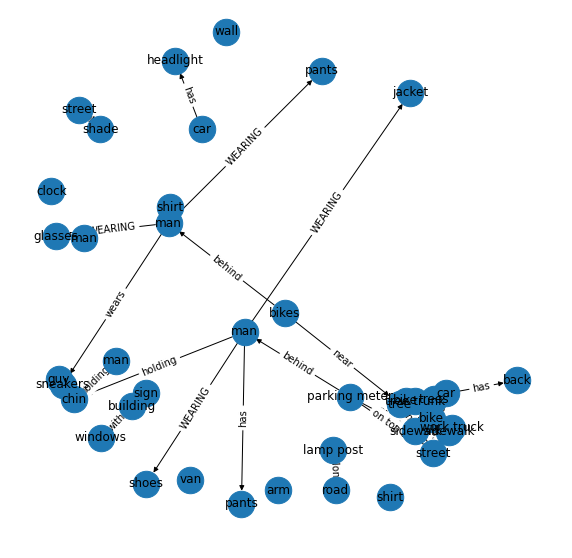

In [88]:
# nx.draw_networkx(G, pos=nx.spring_layout(G), node_size=100, node_color='r', node_shape='o', alpha=0.5,
#                              linewidths=1.0, width=1.0,
#                              )
# # plt.savefig("sample_image_SceneGraph.svg")
# plt.show()
# val_map = {'A': 1.0,
#            'D': 0.5714285714285714,
#            'H': 0.0}

# values = [val_map.get(node, 0.25) for node in G.nodes()]

# nx.draw(G, cmap = plt.get_cmap('jet'), node_color = values)
# plt.show()

# ==================== include info 

plt.figure(figsize=(10,10))
# nx.draw_networkx_labels(G, pos, font_size=16)
node_attrs = {k: v[0] for k, v in nx.get_node_attributes(G,'name').items()}

# nx.draw_networkx_labels(G, pos, labels=node_attrs)

# edge_attrs = nx.get_edge_attributes(G, 'predicate')

# nx.draw_networkx_edges(G, pos, edgelist=edge_attrs, edge_color='r', arrows=True)
# nx.draw(G, connectionstyle='arc3, rad = 0.1',)
# nx.draw_networkx(G, pos=nx.spring_layout(G), node_size=100, node_color='r', node_shape='o', alpha=0.5,
#                              linewidths=1.0, width=1.0,
#                              )
# 

# nx.draw_shell(G, with_labels=True, font_weight='bold')

# nx.draw(G, with_labels=True, node_size=1500, node_color="skyblue", node_shape="s", alpha=0.5, linewidths=40)

# n_nodes = G.number_of_nodes()
# pos = nx.spring_layout(G)
# nx.draw_networkx_edges(G, pos)
# nx.draw_networkx_labels(G, pos)
# mcp = nx.draw_networkx_nodes(G, pos,
#                              node_color=list(range(n_nodes)),
#                              cmap='Blues')
# plt.colorbar(mcp)
# plt.show()

pos = nx.spring_layout(G)  # compute graph layout
nx.draw_networkx_labels(G, pos, labels=node_attrs)  # draw node labels/names
nx.draw_networkx_edge_labels(G, pos, edge_labels=nx.get_edge_attributes(G, 'predicate'))
nx.draw(G, pos, node_size=700)  # draw nodes and edges
plt.show()

# Final SG Plot

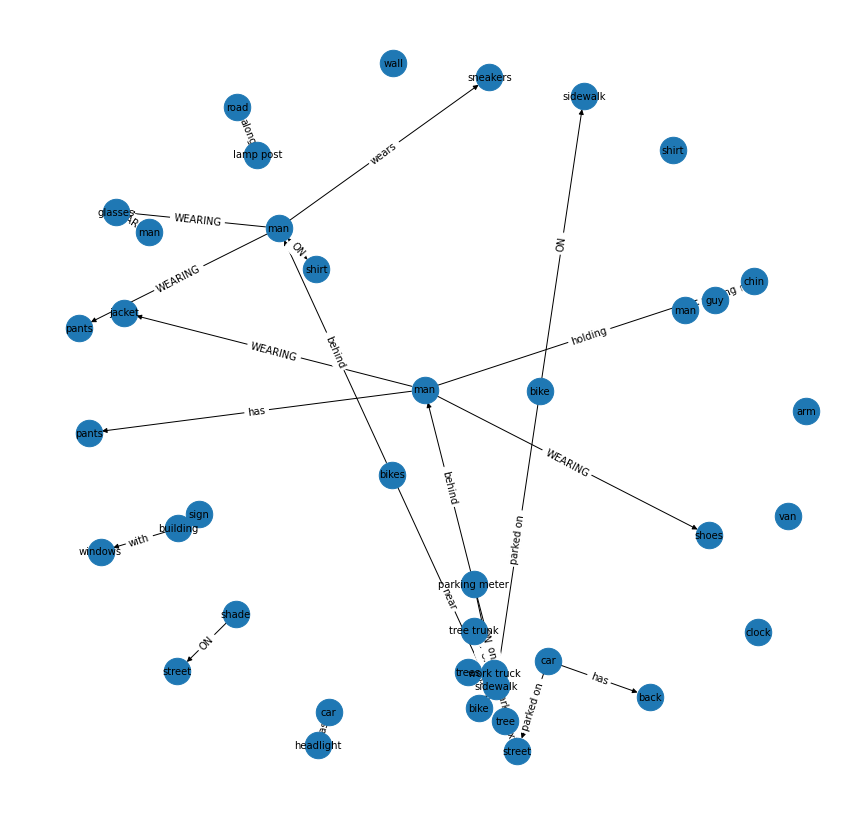

In [111]:
plt.figure(figsize=(15, 15))

pos = nx.spring_layout(G)  # compute graph layout

nx.draw_networkx_nodes(G, pos, node_size=200, node_color="red")
# nx.draw_networkx_nodes(G, pos, nodelist=node_names, node_size=300) # node_color, node_shape, linewidths, label

node_names = {k: v[0] for k, v in nx.get_node_attributes(G,'name').items()}
nx.draw_networkx_labels(G, pos, labels=node_names, font_size=10, alpha=1) # font_weight, font_color

nx.draw_networkx_edge_labels(G, pos, edge_labels=nx.get_edge_attributes(G, 'predicate')) # style, alpha, edge_ cmap, edge_vmin,edge_vmax, arrows

nx.draw(G, pos, node_size=700)  # draw nodes and edges
plt.show()


# pyvis Plotting

In [123]:
from pyvis import network as net

GNet = net.Network("1000px", "1000px", notebook=True, bgcolor="#222222", font_color="white")

for sg_img_obj in sg_img_objs: # name, object_id, [x, y, h, w], ['green', 'tall']
    img_bbox = [sg_img_obj['x'], sg_img_obj['y'], sg_img_obj['w'], sg_img_obj['h']]
    # G.add_node(sg_img_obj['object_id'], name=sg_img_obj['names'], bbox=img_bbox, attr=sg_img_obj.get('attributes'))
    GNet.add_node(sg_img_obj['object_id'], name=sg_img_obj['names'], bbox=img_bbox, attr=sg_img_obj.get('attributes'))

for sg_img_rel in sg_img_rels:
    # G.add_edge(sg_img_rel['subject_id'], sg_img_rel['object_id'], predicate=sg_img_rel['predicate'], rel_id=sg_img_rel['relationship_id'])
    GNet.add_edge(sg_img_rel['subject_id'], sg_img_rel['object_id'], predicate=sg_img_rel['predicate'], rel_id=sg_img_rel['relationship_id'])
 

In [122]:
# # neighbor_map = GNet.get_adj_list()

# # for node in GNet.nodes:
# #     node["title"] += " Neighbors:<br>" + "<br>".join(neighbor_map[node["name"]])
# #     node["value"] = len(neighbor_map[node["name"]])


# GNet.barnes_hut(gravity=-80000, central_gravity=0.3, 
#                 spring_length=250, spring_strength=0.001,
#                 damping=0.09, overlap=0)

# # GNet.show_buttons(filter_=['nodes', 'edges', 'physics'])

# # GNet.show("scratch-pyvis-graph.html")
# GNet.show()

TypeError: 'barnesHut' object is not callable

In [125]:
GNet.barnes_hut()
GNet.show("x.html")

TypeError: 'barnesHut' object is not callable

In [127]:
from pyvis.network import Network
import networkx as nx
nx_graph = nx.cycle_graph(10)
nx_graph.nodes[1]['title'] = 'Number 1'
nx_graph.nodes[1]['group'] = 1
nx_graph.nodes[3]['title'] = 'I belong to a different group!'
nx_graph.nodes[3]['group'] = 10
nx_graph.add_node(20, size=20, title='couple', group=2)
nx_graph.add_node(21, size=15, title='couple', group=2)
nx_graph.add_edge(20, 21, weight=5)
nx_graph.add_node(25, size=25, label='lonely', title='lonely node', group=3)
nt = Network("500px", "500px", notebook=True)
# populates the nodes and edges data structures
nt.from_nx(nx_graph)
nt.show("nx.html")